# Stacked LSTM

In [2]:
# Importing packages
from pathlib import Path
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

Using TensorFlow backend.


In [4]:
project_dir = Path(r'/home/jasonchandatascience/competition_prep/data/pollution')

In [5]:
date_vars = ['DatetimeBegin','DatetimeEnd']

agg_ts = pd.read_csv(project_dir / 'BE_1_2013-2015_aggregated_timeseries.csv', sep='\t', parse_dates=date_vars, date_parser=pd.to_datetime)
meta = pd.read_csv(project_dir / 'BE_2013-2015_metadata.csv', sep='\t')

print('aggregated timeseries shape:{}'.format(agg_ts.shape))
print('metadata shape:{}'.format(meta.shape))

aggregated timeseries shape:(53647, 18)
metadata shape:(1289, 26)


In [6]:
agg_ts.head()

,Countrycode,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,SamplingPoint,AirPollutant,AirPollutantCode,DataAggregationProcess,AirPollutionLevel,UnitOfAirPollutionLevel,DataCapture,DataCoverage,TimeCoverage,DatetimeBegin,DatetimeEnd,Validity,Verification
0,BE,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BELBE06,BELBE06,SPO-BELBE06_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1D,1.0,µg/m3,100.0,83.333333,83.333333,2013-03-01,2013-03-02,1,1
1,BE,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BELBE06,BELBE06,SPO-BELBE06_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1D,1.0,µg/m3,100.0,87.500000,87.500000,2013-02-26,2013-02-27,1,1
2,BE,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BELBE06,BELBE06,SPO-BELBE06_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1D,1.0,µg/m3,100.0,87.500000,87.500000,2013-08-28,2013-08-29,1,1
3,BE,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BELBE06,BELBE06,SPO-BELBE06_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1D,1.0,µg/m3,100.0,95.833333,95.833333,2013-02-02,2013-02-03,1,1
4,BE,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BELBE06,BELBE06,SPO-BELBE06_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1D,1.0,µg/m3,100.0,95.833333,95.833333,2013-02-21,2013-02-22,1,1


In [7]:
meta.head()

,Countrycode,Timezone,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,AirQualityStationNatCode,SamplingPoint,SamplingProcess,Sample,...,Latitude,Altitude,MeasurementType,AirQualityStationType,AirQualityStationArea,EquivalenceDemonstrated,MeasurementEquipment,InletHeight,BuildingDistance,KerbDistance
0,BE,http://dd.eionet.europa.eu/vocabulary/aq/timez...,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BEGBB15,BEGBB15,26BB15,SPO-BEGBB15_06001_100,SPP-BEGBB15_06001_1,SAM-BEGBB15_06001,...,51.213463,5,automatic,background,urban,ref,NaN,2,-999,-999
1,BE,http://dd.eionet.europa.eu/vocabulary/aq/timez...,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BEGR701,BEGR701,26R701,SPO-BEGR701_06001_100,SPP-BEGR701_06001_1,SAM-BEGR701_06001,...,51.058332,5,automatic,background,urban,ref,NaN,2,-999,-999
2,BE,http://dd.eionet.europa.eu/vocabulary/aq/timez...,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BEGR801,BEGR801,26R801,SPO-BEGR801_06001_100,SPP-BEGR801_06001_1,SAM-BEGR801_06001,...,51.209663,6,automatic,background,urban,ref,NaN,2,-999,-999
3,BE,http://dd.eionet.europa.eu/vocabulary/aq/timez...,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BEGR811,BEGR811,26R811,SPO-BEGR811_06001_100,SPP-BEGR811_06001_1,SAM-BEGR811_06001,...,51.252103,8,automatic,background,suburban,ref,NaN,2,-999,-999
4,BE,http://dd.eionet.europa.eu/vocabulary/aq/timez...,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BEGRT01,BEGRT01,26RT01,SPO-BEGRT01_06001_100,SPP-BEGRT01_06001_1,SAM-BEGRT01_06001,...,51.230858,23,automatic,background,rural,ref,NaN,2,-999,-999


# Data Cleaning

In [9]:
ser_avail_days = agg_ts.groupby('SamplingPoint').nunique()['DatetimeBegin']
df = agg_ts.loc[agg_ts.DataAggregationProcess=='P1D', :] 
df = df.loc[df.UnitOfAirPollutionLevel!='count', :]
df = df.loc[df.SamplingPoint.isin(ser_avail_days[ser_avail_days.values >= 1000].index), :]
vars_to_drop = ['AirPollutant','AirPollutantCode','Countrycode','Namespace','TimeCoverage','Validity','Verification','AirQualityStation',
               'AirQualityStationEoICode','DataAggregationProcess','UnitOfAirPollutionLevel', 'DatetimeEnd', 'AirQualityNetwork',
               'DataCapture', 'DataCoverage']
df.drop(columns=vars_to_drop, axis='columns', inplace=True)

In [10]:
dates = list(pd.period_range(min(df.DatetimeBegin), max(df.DatetimeBegin), freq='D').values)
samplingpoints = list(df.SamplingPoint.unique())

new_idx = []
for sp in samplingpoints:
    for d in dates:
        new_idx.append((sp, np.datetime64(d)))

df.set_index(keys=['SamplingPoint', 'DatetimeBegin'], inplace=True)
df.sort_index(inplace=True)
df = df.reindex(new_idx)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # should contain NaN for the columns

df['AirPollutionLevel'] = df.groupby(level=0).AirPollutionLevel.bfill().fillna(0)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # NaN are replaced by values of 2013-01-30
print('{} missing values'.format(df.isnull().sum().sum()))

0 missing values


In [11]:
df = df.loc['SPO-BETR223_00001_100',:]

In [13]:
import seaborn as sns ; sns.set()

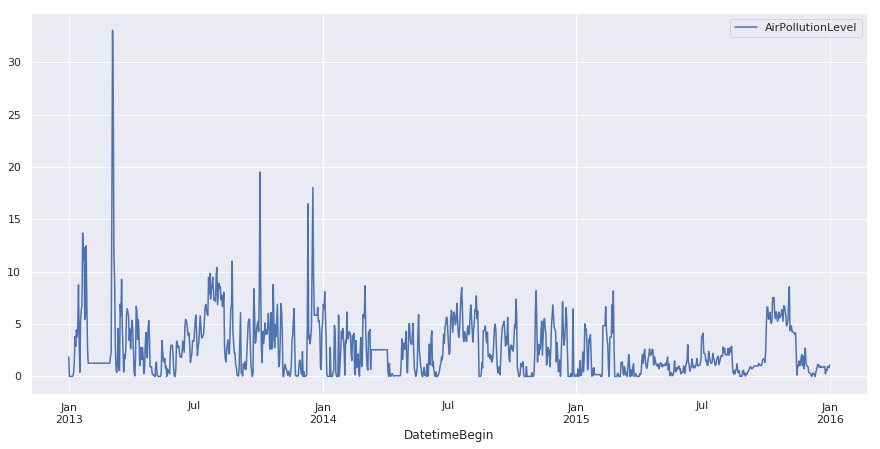

In [16]:
df.plot(figsize=(15, 7))

# Train, Test, Valid Split

In [39]:
train = df.query('DatetimeBegin < "2014-07-01"')
valid = df.query('DatetimeBegin >= "2014-07-01" and DatetimeBegin < "2015-01-01"')
test = df.query('DatetimeBegin >= "2015-01-01"')

In [40]:
# Save column names and indices to use when storing as csv
cols = train.columns
train_idx = train.index
valid_idx = valid.index
test_idx = test.index

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
valid = scaler.transform(valid)
test = scaler.transform(test)

In [41]:
train = pd.DataFrame(train, columns=cols, index=train_idx)
valid = pd.DataFrame(valid, columns=cols, index=valid_idx)
test = pd.DataFrame(test, columns=cols, index=test_idx)

In [21]:
train.shape

(546, 1)

In [22]:
valid.shape

(184, 1)

In [23]:
test.shape

(365, 1)

# Modelling

In [24]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

## Time Series Generator

Using EarlyStopping to stop if no improvement in 10 epochs and ModelCheckPoint to save weights of the best model

In [42]:
train = train.values.reshape(len(train), 1)
valid = valid.values.reshape(len(valid), 1)
test = test.values.reshape(len(test), 1)

In [43]:
n_lag = 14

train_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 5)
valid_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen = TimeseriesGenerator(test, test, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)

In [61]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(4, input_shape=(14, 1)))
simple_rnn.add(Dense(1))

In [62]:
simple_rnn.compile(loss='mae', optimizer = 'rmsprop')

In [63]:
model_dir = Path(r'/home/jasonchandatascience/competition_prep/model/pollution')

In [64]:
checkpointer = ModelCheckpoint(filepath= str(model_dir / 'simple_rnn_weights.hdf5'), verbose=0, save_best_only=True)

In [65]:
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

In [66]:
# save model architecture to json

with open(model_dir / "simple_rnn.json", "w") as m: 
    m.write(simple_rnn.to_json())

In [67]:
simple_rnn_history = simple_rnn.fit_generator(train_data_gen, epochs=100, validation_data=valid_data_gen, verbose=0, callbacks=[checkpointer, earlystopper])

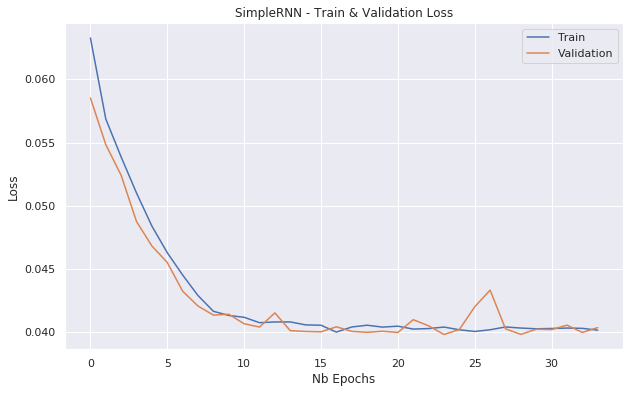

Minimum validation loss of 0.03982634324128775 reached at epoch 23


In [68]:
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')